In [1]:
import os
import pandas as pd
import numpy as np
import nltk
import torch
import json

from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA
from torchviz import make_dot

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from fastText import load_model

%run pretty_print_cf

pd.set_option('display.max_colwidth', 1000)

In [2]:
def analyze(filename):
    df = pd.read_csv(filename, header=-1)
    df.columns = ['pred', 'label'] # Distribution of templates
    
    for id in df['label'].value_counts().index:
        subset = df[df['label'] == id]
        correct = (subset['pred'] == subset['label']).sum()
        accuracy = correct / len(subset)

        false_positive_subset = df[df['pred'] == id]
        false_positives = (false_positive_subset['pred'] != false_positive_subset['label']).sum()
        false_positive_rate = false_positives / max(len(false_positive_subset), 1)

        print("=" * 50)
        print("Template #{}: count={}, correct={}, false_positives={}, accuracy={}, false_positive_rate={}"
              .format(id, len(subset), correct, false_positives, accuracy, false_positive_rate))
        print("=" * 50)
    return df

In [ ]:
df = analyze("analysis/expname=reverting to old ways with lower learning rate,input_dim=444,mem_dim=150,lr=0.001,emblr=0.01,wd=0.0001,epochs=50,current_epoch=8,test_acc=0.786,loss=0.6967378057959431.csv")

In [6]:
# Prediction k-templates
saved_model = torch.load('checkpoints/Corrected spelling mistakes,epoch=47,test_acc=0.8246887966804979.pt')
trainer = saved_model['trainer']
test_dataset = torch.load('data/lc-quad/pth/lc_quad_test.pth')

In [7]:
# trainer.model.eval()
# trainer.test_embeddings()

accuracy = 0
top_2_accuracy = 0

y_true = []
y_pred = []
output_vocab = trainer.vocabs['output']

df_list = []
for index in range(len(test_dataset)):
    torch.no_grad()
    tree, emb, target = trainer.get_data(test_dataset[index], test_dataset.num_classes)
    output = trainer.model.forward(tree, emb, training=False)
    _, pred = torch.topk(output[0].squeeze(0), 2)
    
    pred = pred.numpy()
    target = target.numpy()
    
    pred_0 = output_vocab.idxToLabel[pred[0]]
    pred_1 = output_vocab.idxToLabel[pred[1]]
    target = output_vocab.idxToLabel[target[0]]    
    
    output_list = output[0].squeeze(0).detach().numpy().tolist()
    output_list.append(target)
    df_list.append(output_list)
        
    y_true.append(target)
    y_pred.append(pred_0)
    
    if pred_0 == target:
        accuracy += 1
        top_2_accuracy += 1
    elif pred_1 == target:
        top_2_accuracy += 1
        
print(accuracy / len(test_dataset), top_2_accuracy / len(test_dataset))

0.8163900414937759 0.9387966804979253


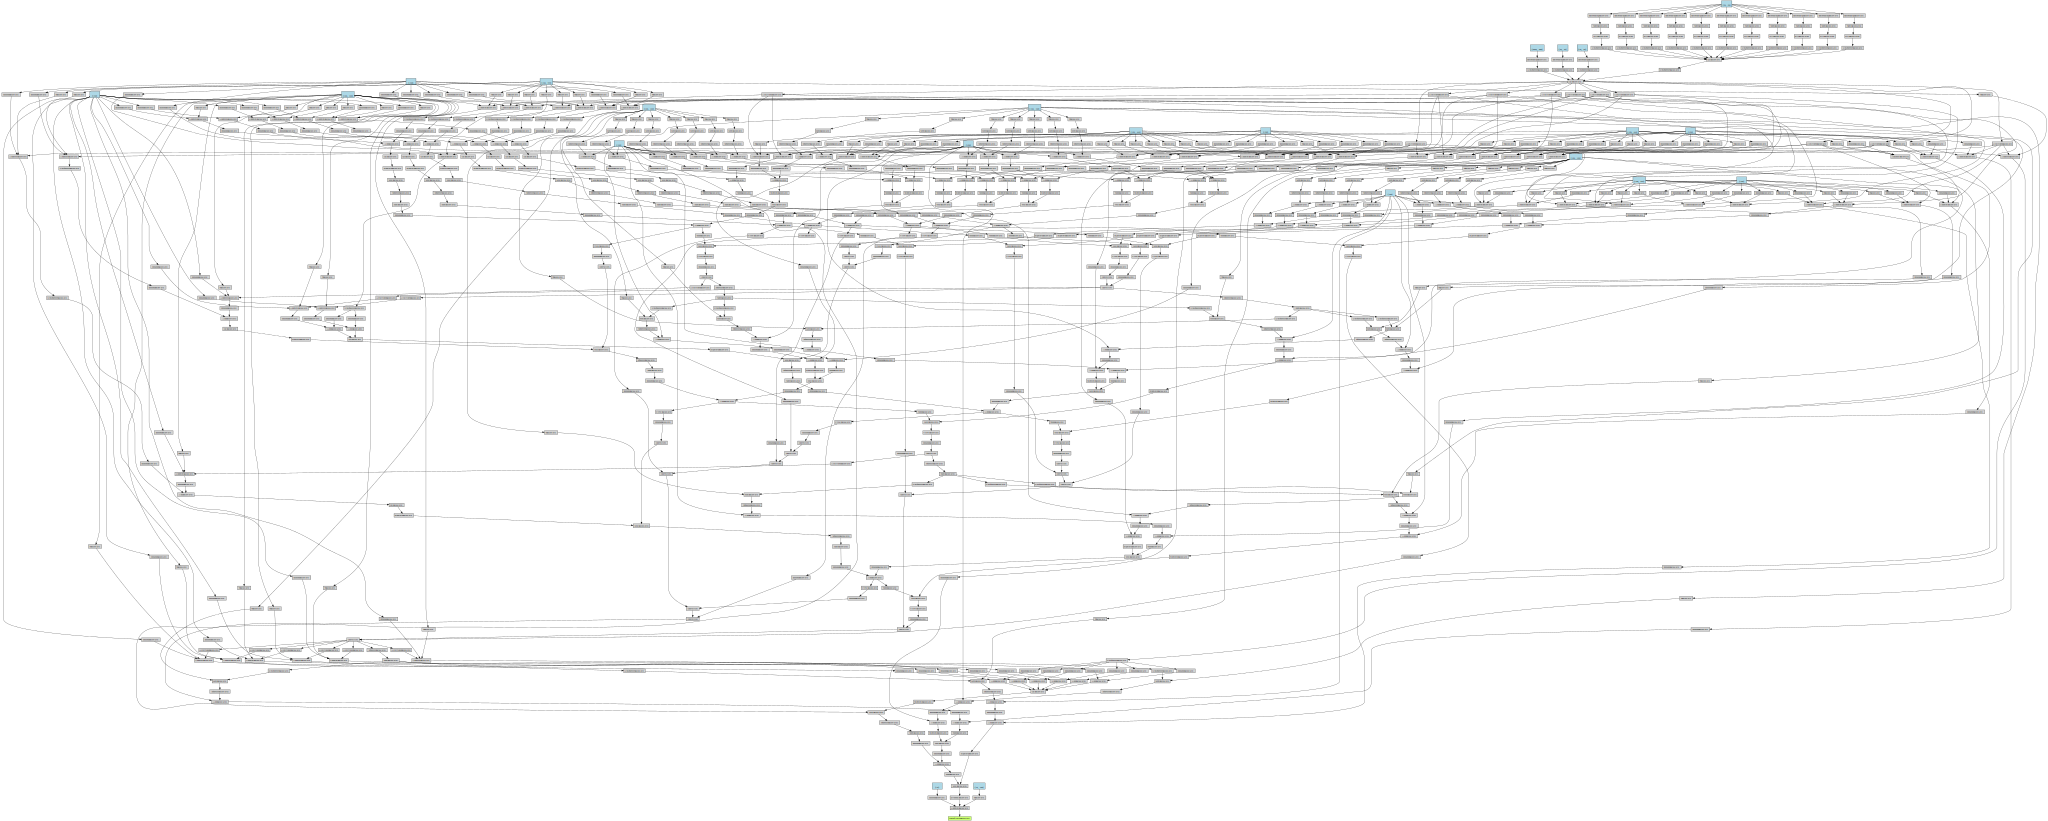

In [7]:
tree, emb, target = trainer.get_data(test_dataset[0], test_dataset.num_classes)
output = trainer.model.forward(tree, emb)
make_dot(output)

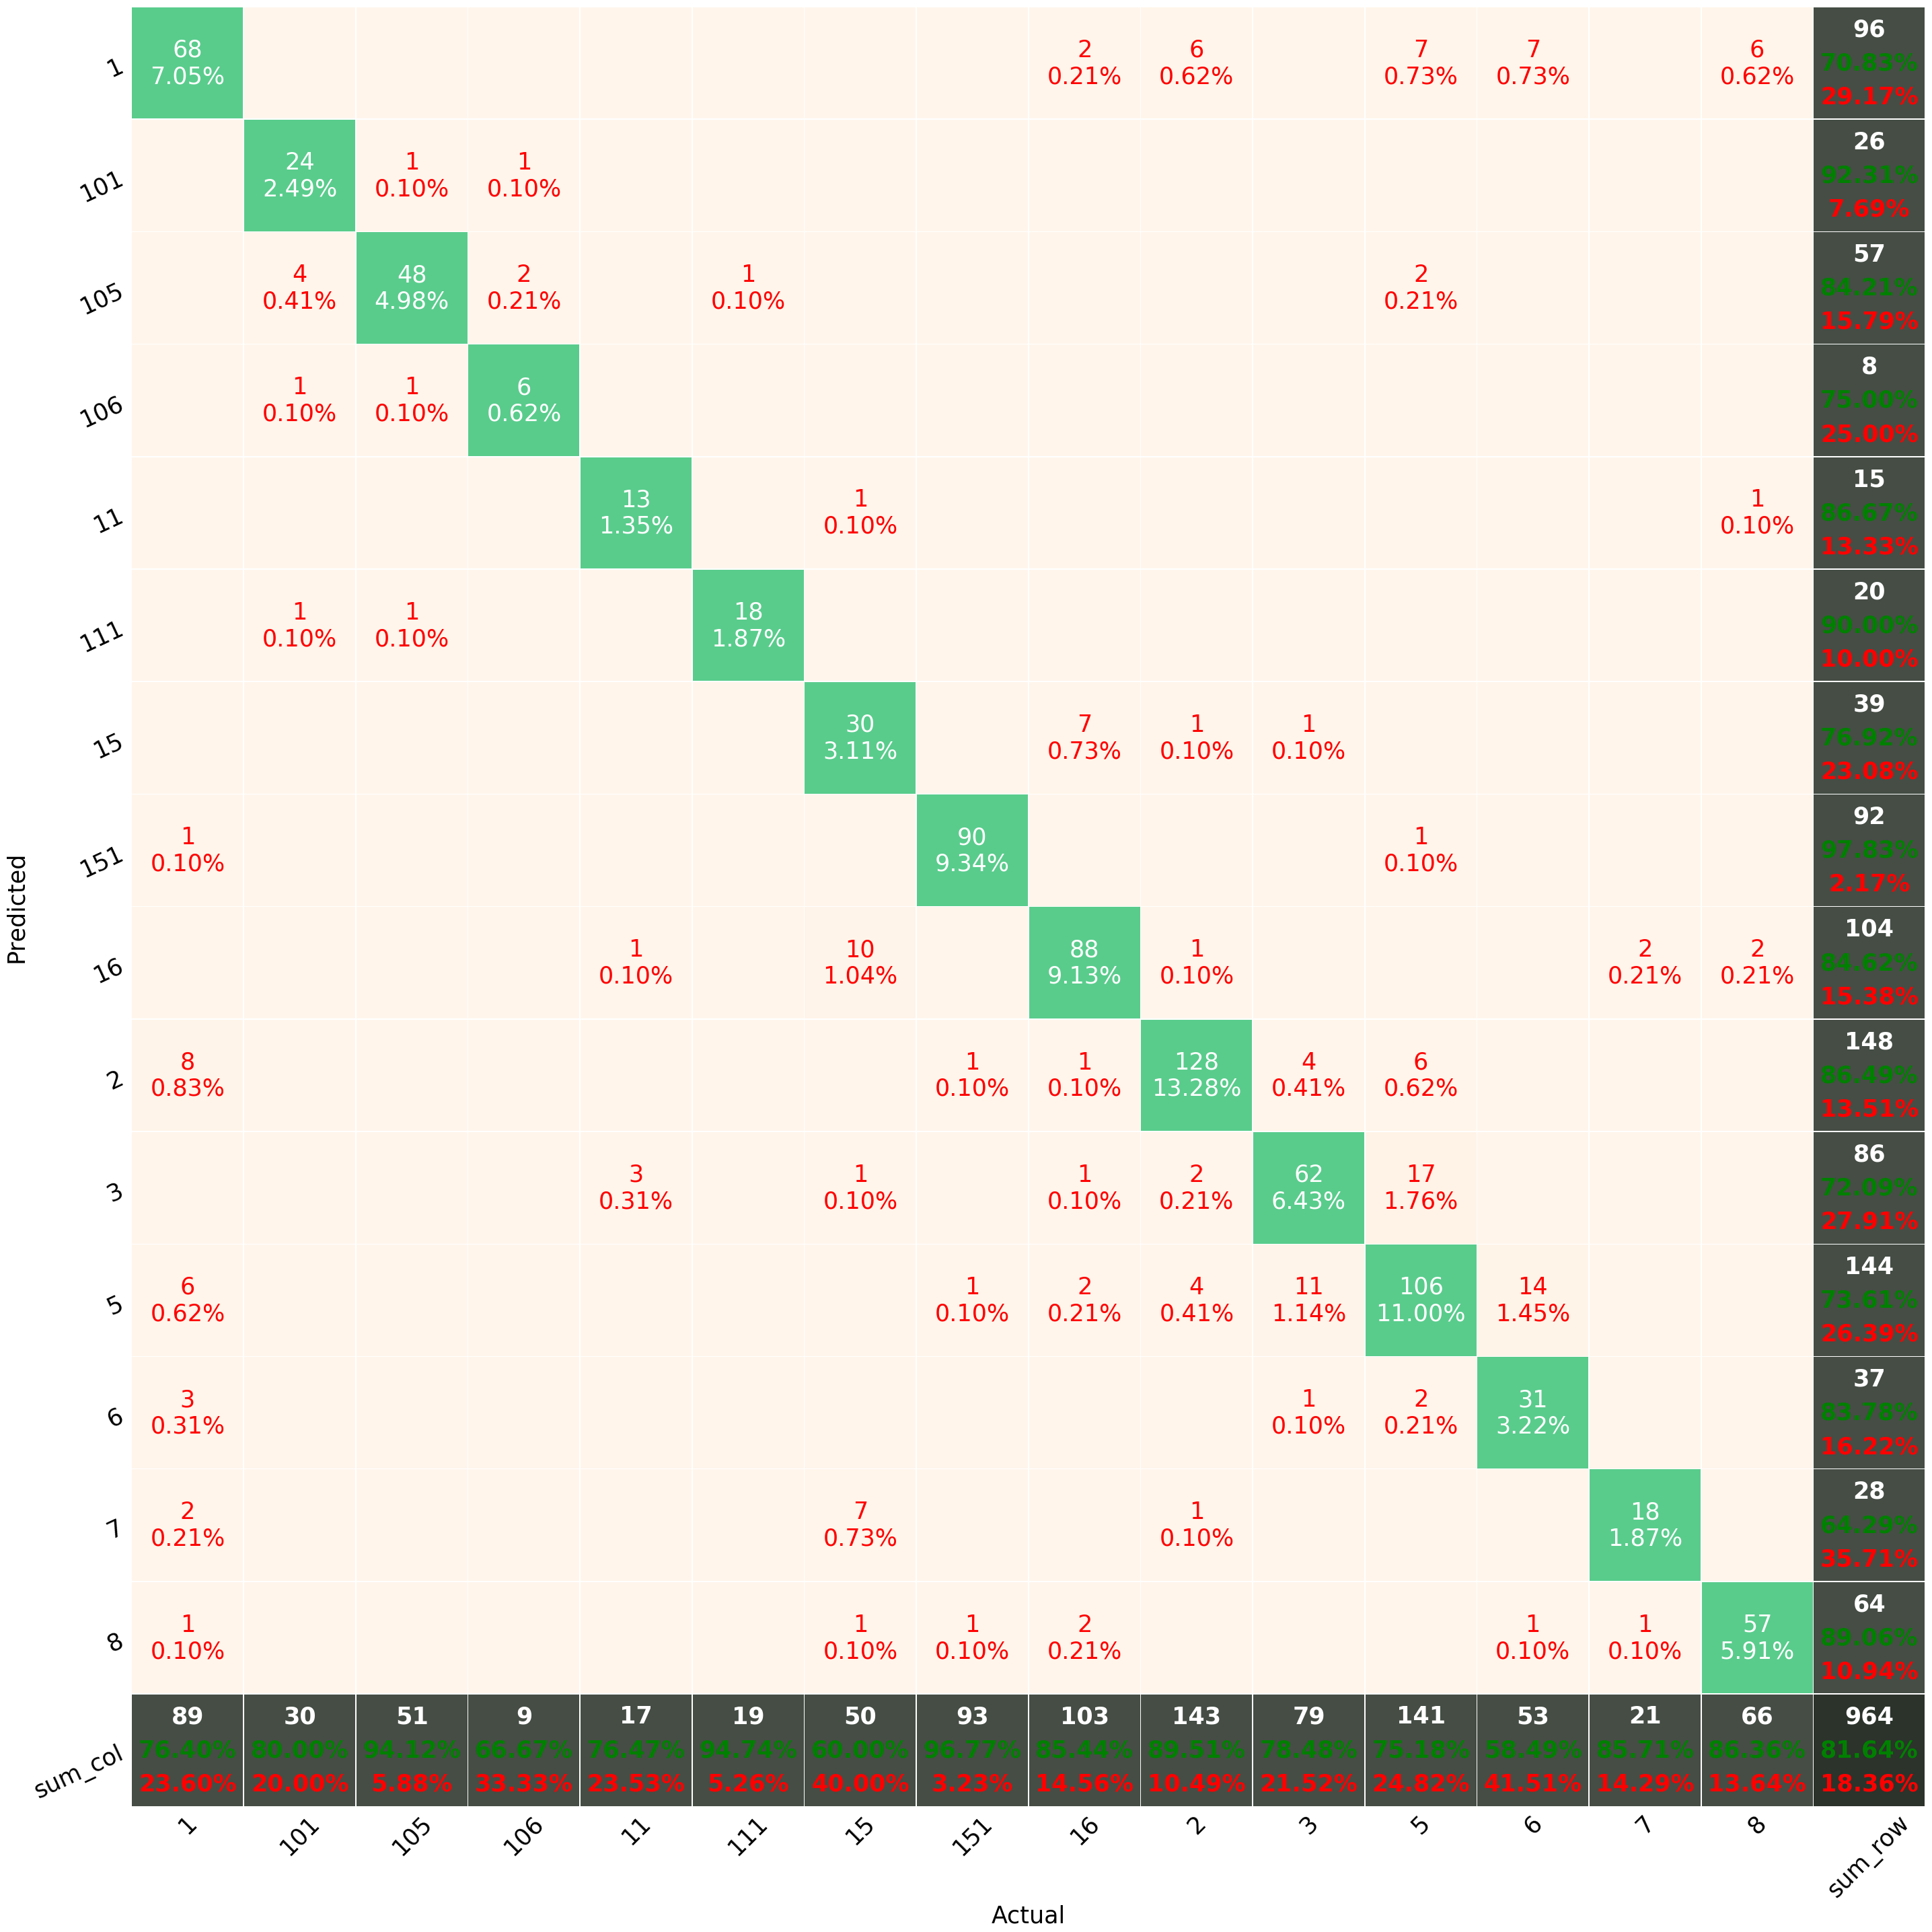

In [8]:
class_names = list(output_vocab.idxToLabel.values())
matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(matrix, index=class_names, columns=class_names)
plt = pretty_plot_confusion_matrix(df_cm, figsize=[40, 40], fz=35)
plt.savefig('confusion_matrix.png')
plt.show()

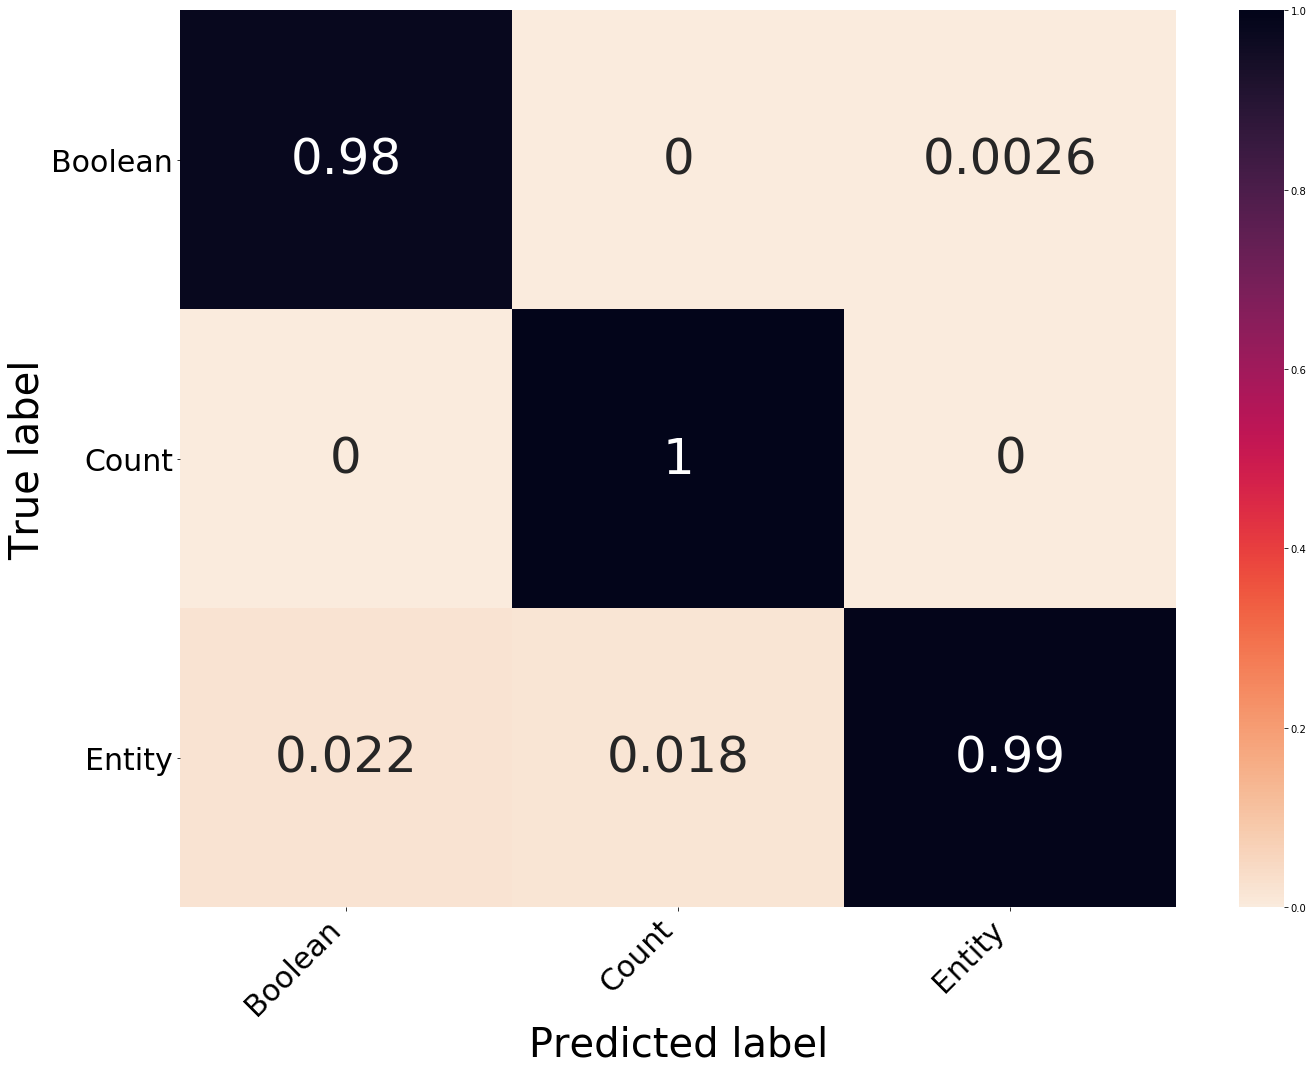

In [161]:
type_true = []
type_pred = []

def get_type(value):
    value = int(value)
    if value < 100:
        return 'Entity'
    elif value == 151:
        return 'Boolean'
    else:
        return 'Count'

for index in range(len(y_true)):
    type_true.append(get_type(y_true[index]))
    type_pred.append(get_type(y_pred[index]))
    
class_names = list(['Boolean', 'Count', 'Entity'])
matrix = confusion_matrix(type_true, type_pred)
df_cm = pd.DataFrame(matrix, index=class_names, columns=class_names)
df_cm = df_cm.astype('float') / df_cm.sum(axis=1)

fig = plt.figure(figsize=(20, 15))
cmap = sns.cm.rocket_r
heatmap = sns.heatmap(df_cm, annot=True, cmap=cmap, annot_kws=dict(size=50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=30)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=30)
plt.ylabel('True label', size=40)
plt.xlabel('Predicted label', size=40)
plt.tight_layout()
plt.savefig('type_confusion_matrix.png')
plt.show()    

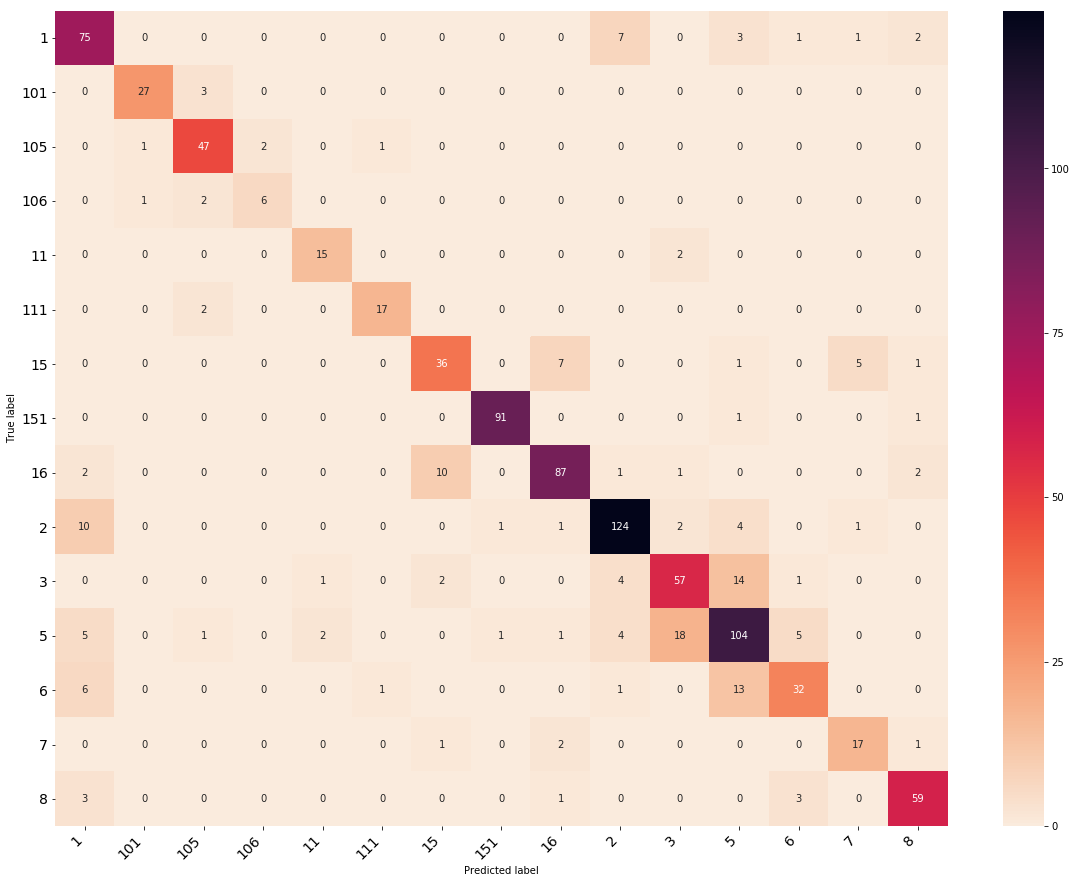

In [32]:
class_names = list(output_vocab.idxToLabel.values())
matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(matrix, index=class_names, columns=class_names)

fig = plt.figure(figsize=(20, 15))
cmap = sns.cm.rocket_r
heatmap = sns.heatmap(df_cm, annot=True, cmap=cmap, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion matrix.png')
plt.show()

In [21]:
df = pd.DataFrame(df_list)

In [22]:
df_group = df.groupby([df.columns[-1]])[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].mean()

In [23]:
df_t = df_group.T
df_corr = df_t.corr()

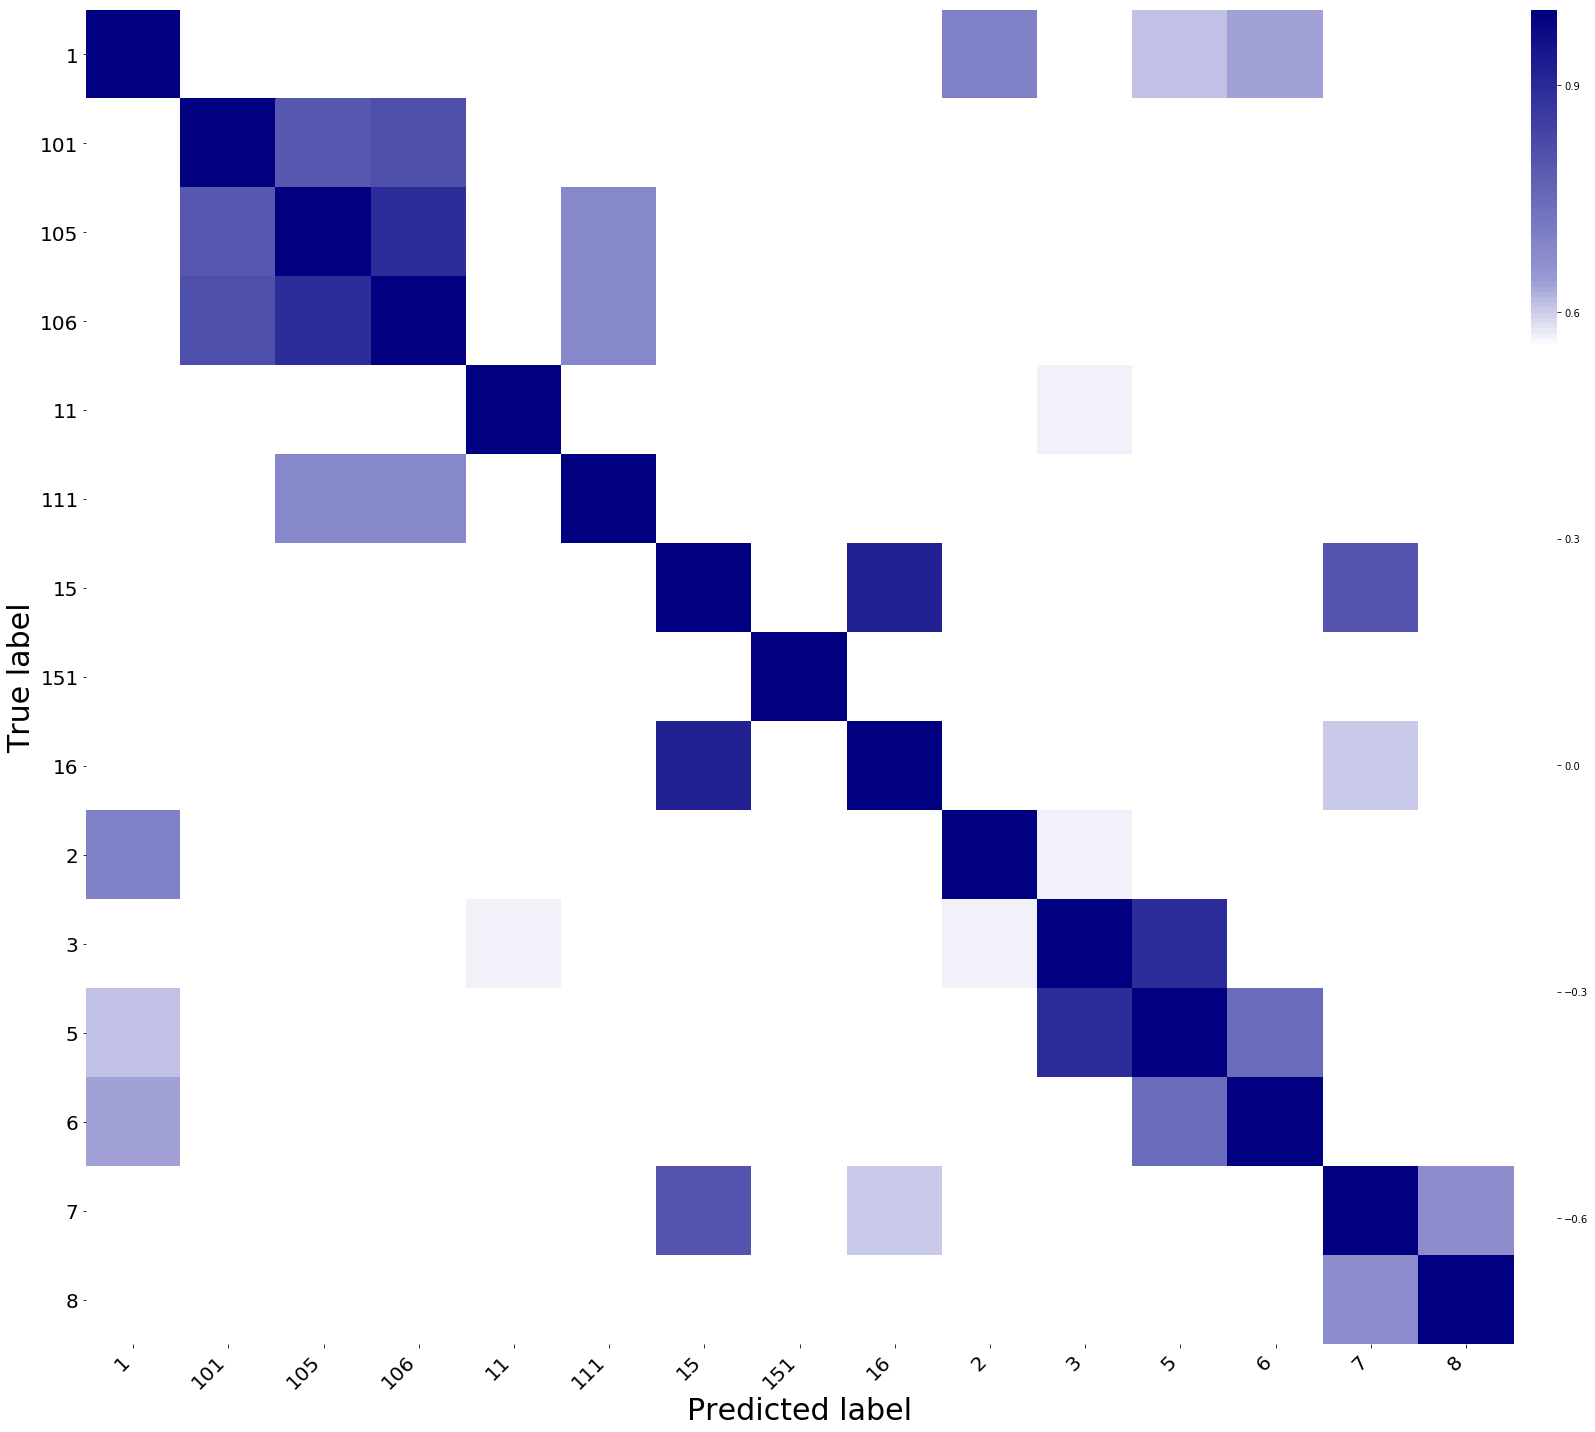

In [126]:
class_names = df_corr.columns
matrix = confusion_matrix(y_true, y_pred)

fig = plt.figure(figsize=(25, 20))
cmap = sns.cm.rocket_r

boundaries = [0.0, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
hex_colors = sns.light_palette('navy', n_colors=len(boundaries), as_cmap=False).as_hex()

hex_colors[0] = '#ffffff'
hex_colors[1] = '#ffffff'

cmap = [hex_colors[i] for i in range(0, len(hex_colors), 2)]
colors=list(zip(boundaries, hex_colors))

custom_color_map = LinearSegmentedColormap.from_list(
    name='custom_navy',
    colors=colors
)

heatmap = sns.heatmap(df_corr, annot=False, cmap=custom_color_map, cbar_kws=dict(use_gridspec=True, aspect=50, pad=0.01))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=20)
plt
plt.ylabel('True label', size=30)
plt.xlabel('Predicted label', size=30)
plt.tight_layout()
plt.savefig('pearson_matrix.png', pad_inches=0)
plt.show()

In [125]:
df_corr.columns

Index(['1', '101', '105', '106', '11', '111', '15', '151', '16', '2', '3', '5',
       '6', '7', '8'],
      dtype='object', name=15)

In [91]:
pca = PCA(n_components=2)
pca.fit(df[:-1])

columns = ['pca_%i' % i for i in range(2)]
df_pca = DataFrame(pca.transform(df), columns=columns, index=df.index)
df_pca['template'] = df[df.columns[-1]]

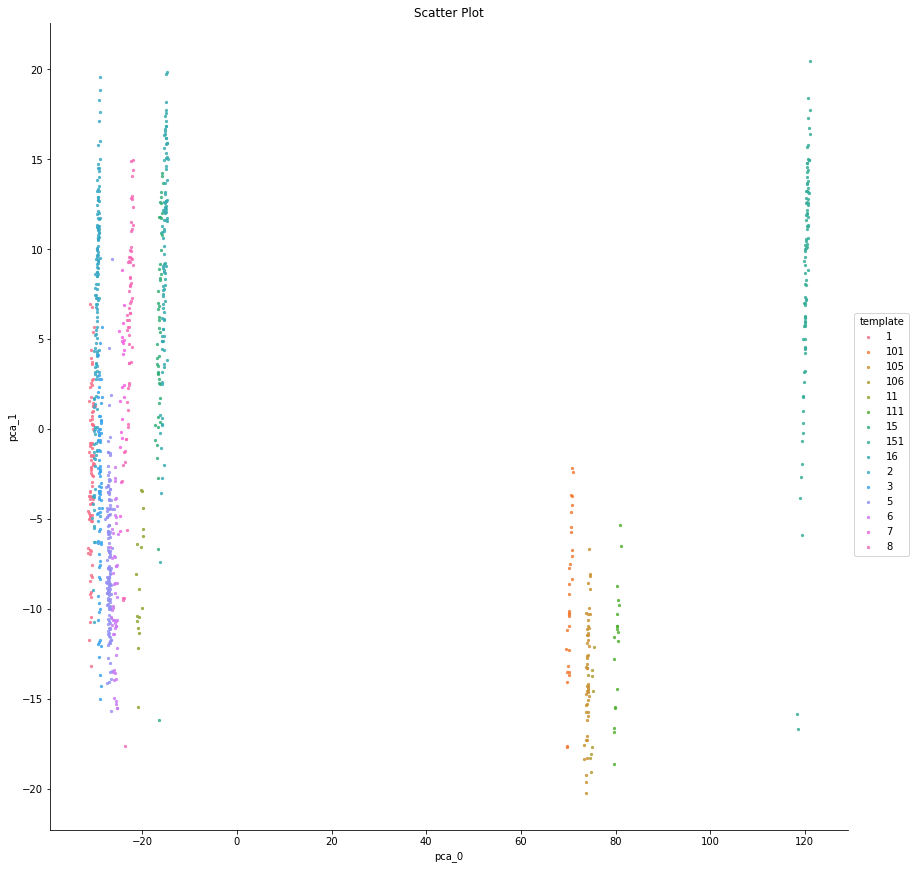

In [172]:
sns.lmplot('pca_0', # Horizontal axis
           'pca_1', # Vertical axis
           size=12,
           data=df_pca, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="template", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 5}) # S marker size
# Set title
plt.title('Scatter Plot')

# Set x-axis label
plt.xlabel('pca_0')

# Set y-axis label
plt.ylabel('pca_1')
plt.savefig('scatter.png')
plt.show()

In [32]:
def get_top_k_accuracy(qald, template=None):
    accuracy = 0
    top_2_accuracy = 0
    actuals = []
    count = 0
    
    for index in range(len(qald)):        
        actual = qald[index]['actual']
        
        if template != None and actual != template:
            continue
        
        preds = qald[index]['predictions'].split(',')
        if preds[0] == actual:
            accuracy += 1
            top_2_accuracy += 1
        elif preds[1] == actual:
            top_2_accuracy += 1        
        count += 1
        
    return accuracy / count, top_2_accuracy / count, count

In [29]:
with open('data/qald/qald.json') as f:
    qald = json.load(f)

accuracy = 0
top_2_accuracy = 0

y_true = []
y_pred = []

for index in range(len(qald)):
    actual = qald[index]['actual']
    preds = qald[index]['predictions'].split(',')
    
    y_true.append(actual)
    y_pred.append(preds[0])
    
    if preds[0] == actual:
        accuracy += 1
        top_2_accuracy += 1
    elif preds[1] == actual:
        top_2_accuracy += 1

print(accuracy / len(qald), top_2_accuracy / len(qald))

0.6183206106870229 0.7862595419847328


In [33]:
unique_templates = pd.Series(y_true).unique().tolist()

for template in unique_templates:
    print(template, get_top_k_accuracy(qald, template))

1 (0.6666666666666666, 0.9444444444444444, 18)
2 (0.675, 0.8375, 80)
3 (0.25, 0.4166666666666667, 12)
8 (0.0, 0.3333333333333333, 6)
7 (0.0, 0.0, 1)
151 (1.0, 1.0, 12)
5 (0.0, 0.0, 1)
11 (0.0, 0.0, 1)


/Users/rgathrey/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


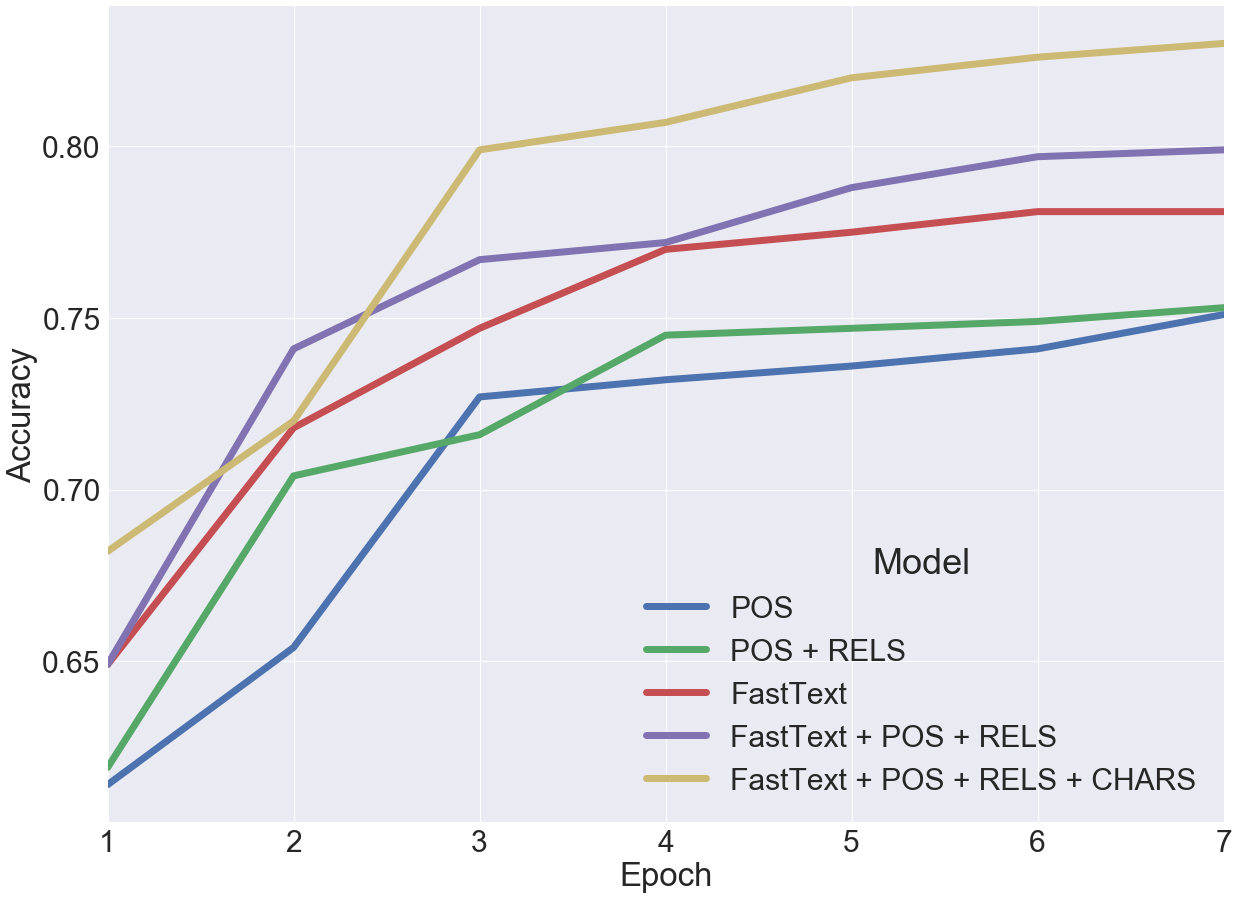

In [61]:
df = pd.DataFrame({
    'Epoch': [1, 2, 3, 4, 5, 6, 7, 
            1, 2, 3, 4, 5, 6, 7,
            1, 2, 3, 4, 5, 6, 7,
            1, 2, 3, 4, 5, 6, 7,
            1, 2, 3, 4, 5, 6, 7],
    'Model': ['POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS',
                  'POS + RELS', 'POS + RELS', 'POS + RELS', 'POS + RELS', 'POS + RELS', 'POS + RELS', 'POS + RELS',
                  'FastText', 'FastText', 'FastText', 'FastText', 'FastText', 'FastText', 'FastText',
                  'FastText + POS + RELS', 'FastText + POS + RELS', 'FastText + POS + RELS', 'FastText + POS + RELS', 'FastText + POS + RELS', 'FastText + POS + RELS', 'FastText + POS + RELS',
                  'FastText + POS + RELS + CHARS', 'FastText + POS + RELS + CHARS', 'FastText + POS + RELS + CHARS', 'FastText + POS + RELS + CHARS', 'FastText + POS + RELS + CHARS', 'FastText + POS + RELS + CHARS', 'FastText + POS + RELS + CHARS'
                 ],
    'Accuracy': [0.614, 0.654, 0.727, 0.732, 0.736, 0.741, 0.751,
              0.619, 0.704, 0.716, 0.745, 0.747, 0.749, 0.753,
              0.649, 0.718, 0.747, 0.770, 0.775, 0.781, 0.781,
              0.649, 0.741, 0.767, 0.772, 0.788, 0.797, 0.799,
              0.682, 0.720, 0.799, 0.807, 0.820, 0.826, 0.830
    ]
})


plt.figure(figsize=(20, 15))
sns.set(font_scale=3)
sns.tsplot(df, time='Epoch', unit = "Model", 
               condition='Model', value='Accuracy', linewidth=7)
plt.savefig('model_accuracy.png')
plt.show()